In [1]:
using Random
using Distributions
using LinearAlgebra
include("../Inversion/IPS.jl")
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

In [2]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

Setup_Param

# Twomodal posterior

We will explore the question with the following inverse problem 

$$
\begin{align*}
y = 
(\theta_{(1)} - \theta_{(2)})^2 
+\eta
\qquad 
y_{ref} = 4.2297
\begin{bmatrix}
0\\
0
\end{bmatrix} 
\qquad
\Sigma_{\eta} = I
\end{align*}
\qquad 
\theta_{\rm prior} = \mathcal{N(\mu_0, I)}
$$

We focus on the Gaussian prior $\mathcal{N}(0, 1^2 I)$ and $\mathcal{N}([0.5, 0]^T, 1^2 I)$.
     

In [3]:
function func_G(θ)
    θ₁, θ₂ = θ
    return [(θ₂ - θ₁)^2;]
end

function log_prior(θ, μ0, σ0)
    θ₁, θ₂ = θ
    return -((θ₁ - μ0[1])^2 + (θ₂ - μ0[2])^2)/(2σ0^2)
end

function log_twomodal(θ, μ0, σ0, y, ση)
    θ₁, θ₂ = θ
    return -(y[1] - func_G(θ)[1])^2/(2ση^2) + log_prior(θ, μ0, σ0)
end

function forward(s_param::Setup_Param, θ)
    return func_G(θ)
end


forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)



#39 (generic function with 1 method)

In [4]:
using ForwardDiff
using KernelDensity
function twomodal(μ0 = [0.0;0.0]; Run_Fisher_Rao = false)

    σ0 = 1.0
    Σ0 = [σ0^2 0.0;0.0  σ0^2]

    ση = 1.0
    Σ_η = [ση^2;;]
    y = [4.2297;]

    @info "y = ", y

    

    N_y, N_θ = 1, 2
    # compute posterior distribution by GMKI
    update_freq = 1
    N_iter = 30
    N_modes = 3
    θ0_w  = ones(N_modes)/N_modes
    θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)


    Random.seed!(2);
    for m = 1:N_modes
        θ0_mean[m, :]    .= rand(MvNormal(zeros(N_θ), Σ0)) + μ0
        θθ0_cov[m, :, :] .= Σ0
    end


    s_param_aug = Setup_Param(N_θ, N_y+N_θ)
    y_aug = [y ; μ0]

    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
    
    
    Δt = 0.5
    gmkiobj = GMKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, Δt, update_freq, N_iter; unscented_transform="modified-2n+1")
    
    
    
    if Run_Fisher_Rao
        s_param = Setup_Param(N_θ, N_y)
        N_ens  = 1000
        method  = "Wasserstein-Fisher-Rao"
        preconditioner = false             # true
        Δt, N_t = 1e-2, 10^3
        
        logρ = θ ->log_twomodal(θ, μ0, σ0, y, ση)
        
        function compute_∇logρ(s_param, θ)
            return logρ(θ), ForwardDiff.gradient(logρ, θ)
        end   
        θ0 = Array(rand(MvNormal(μ0, Σ0), N_ens)')   
        # median vs fix covariance to 0.1^2
        kernel_param = nothing
        ipsobj = IPS_Run(s_param, compute_∇logρ, θ0, N_ens, Δt, N_t, method, preconditioner, kernel_param)
        
    end
    
    

    # visualization 
    x_min, x_max = -4.0, 4.0
    y_min, y_max = -4.0, 4.0
    Nx, Ny = 2000, 2000
    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'       #'
    
    Z_ref = copy(X)
    for i = 1:Nx
        for j = 1:Ny
            temp = [X[i,j] ; Y[i,j]]
            Z_ref[i,j] = exp(log_twomodal(temp, μ0, σ0, y, ση))
        end
    end
    Z_ref /= ( sum(Z_ref)*(xx[2]-xx[1])*(yy[2]-yy[1]) )
    
    
    

    fig, ax = PyPlot.subplots(nrows=1, ncols=4, sharex=false, sharey=false, figsize=(16,4))
    

        
    # plot reference
    color_lim = (minimum(Z_ref), maximum(Z_ref))
    ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)
    ax[1].set_xlabel(L"\theta_{(1)}")
    ax[1].set_ylabel(L"\theta_{(2)}")
    ax[1].set_title("Reference")
        
    
    # plot Wasserstein Fisher Rao 
    if Run_Fisher_Rao

        θs = ipsobj.θ[end]

        kernel = kde(θs)
        Z = pdf(kernel, xx, yy)
        Z /= (sum(Z)*(xx[2]-xx[1])*(yy[2]-yy[1]) )
        ax[3].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
        ax[3].scatter([θs[:,1];], [θs[:,2];], marker="o", color="b", s=2, alpha=0.2)

        ax[3].set_xlabel(L"\theta_{(1)}")
        ax[3].set_ylabel(L"\theta_{(2)}")
        ax[3].set_title("BDLS-KL")

        @info "Fisher-Rao L₁ error = ", sum(abs.(Z - Z_ref))/sum(abs.(Z_ref))
    end
            
            
          
    # plot GMKI results 
    Z = zeros(N_modes, Nx, Ny)
    error = zeros(N_iter+1)        
    for iter = 0:N_iter  
        for i =1:N_modes
            gmki_θ_mean = gmkiobj.θ_mean[iter+1][i, :]
            gmki_θθ_cov = gmkiobj.θθ_cov[iter+1][i, :, :]
            _,_, Z[i, :, :] = Gaussian_2d(gmki_θ_mean, gmki_θθ_cov, Nx, Ny, x_min, x_max, y_min, y_max) 
            Z[i,:,:] *= exp(gmkiobj.logθ_w[iter+1][i])

        end
        Z_GMKI = sum(Z, dims=1)[1,:,:]
        Z_GMKI /= (sum(Z_GMKI)*(xx[2]-xx[1])*(yy[2]-yy[1]) )
        error[iter+1] = sum(abs.(Z_GMKI - Z_ref))*(xx[2]-xx[1])*(yy[2]-yy[1])
            
            
        if iter == N_iter    
            ax[2].pcolormesh(X, Y, Z_GMKI, cmap="viridis", clim=color_lim)
            linestyles = ["o"; "x"; "s"]
            for i =1:N_modes
                gmki_θ_mean = gmkiobj.θ_mean[iter][i, :]
                gmki_θθ_cov = gmkiobj.θθ_cov[iter][i, :, :]
                ax[2].scatter([gmki_θ_mean[1];], [gmki_θ_mean[2];], marker=linestyles[i], color="C"*string(i), facecolors=(linestyles[i]=="x" ? nothing : "none"), linewidths=3)
                ax[2].scatter([gmkiobj.θ_mean[1][i, :][1];], [gmkiobj.θ_mean[1][i, :][2];], marker=linestyles[i], color="black", facecolors=(linestyles[i]=="x" ? nothing : "none"), linewidths=3)
            end

            ax[2].set_xlabel(L"\theta_{(1)}")
            ax[2].set_ylabel(L"\theta_{(2)}")
            ax[2].set_title("GMKI")
            @info "GMKI L₁ error = ", sum(abs.(Z_GMKI - Z_ref))*(xx[2]-xx[1])*(yy[2]-yy[1])
                    
            ax[4].plot(Array(0:N_iter), error, label="(K="*string(N_modes)*")")
        end
        
    end
    
    
    ax[4].set_title("GMKI")
    ax[4].set_xlabel("Iterations")
    ax[4].set_ylabel("TV distance")
    ax[4].set_yticks([0.1; 0.4; 0.7; 1.0]) 
    fig.tight_layout()
    fig.savefig("2D-density-"*string(μ0[1])*"-"*string(N_iter)*".png")

    
end





twomodal (generic function with 2 methods)

[ Info: ("y = ", [4.2297])
[ Info: Start GMKI on the mean-field stochastic dynamical system for Bayesian inference 
[ Info: ("Fisher-Rao L₁ error = ", 0.5511112004617803)
[ Info: ("GMKI L₁ error = ", 0.12490567941301786)


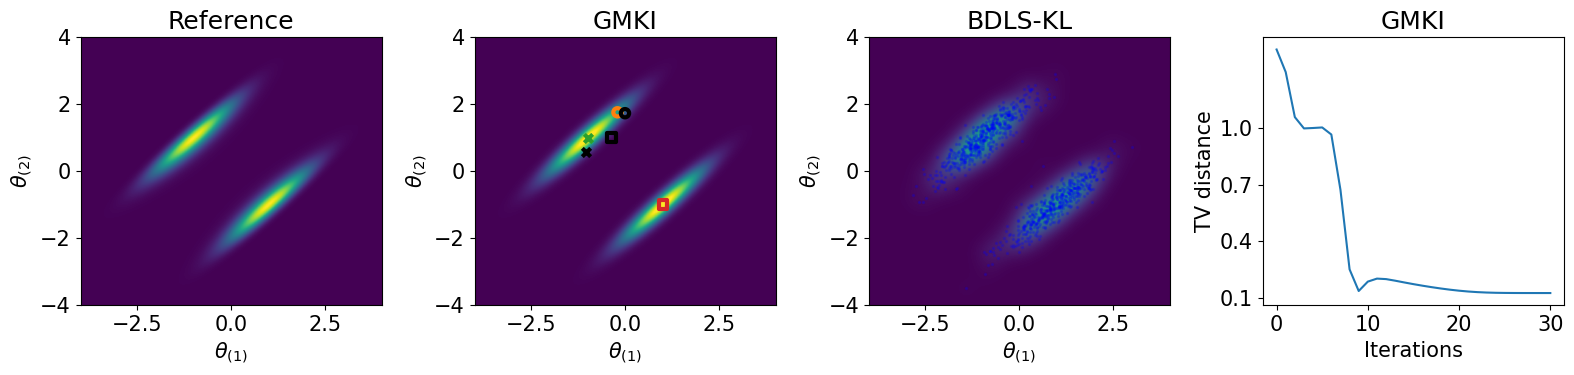

In [5]:
twomodal([0.0;0.0]; Run_Fisher_Rao=true)

[ Info: ("y = ", [4.2297])
[ Info: Start GMKI on the mean-field stochastic dynamical system for Bayesian inference 
[ Info: ("Fisher-Rao L₁ error = ", 0.5287443368315051)
[ Info: ("GMKI L₁ error = ", 0.1272510135781716)


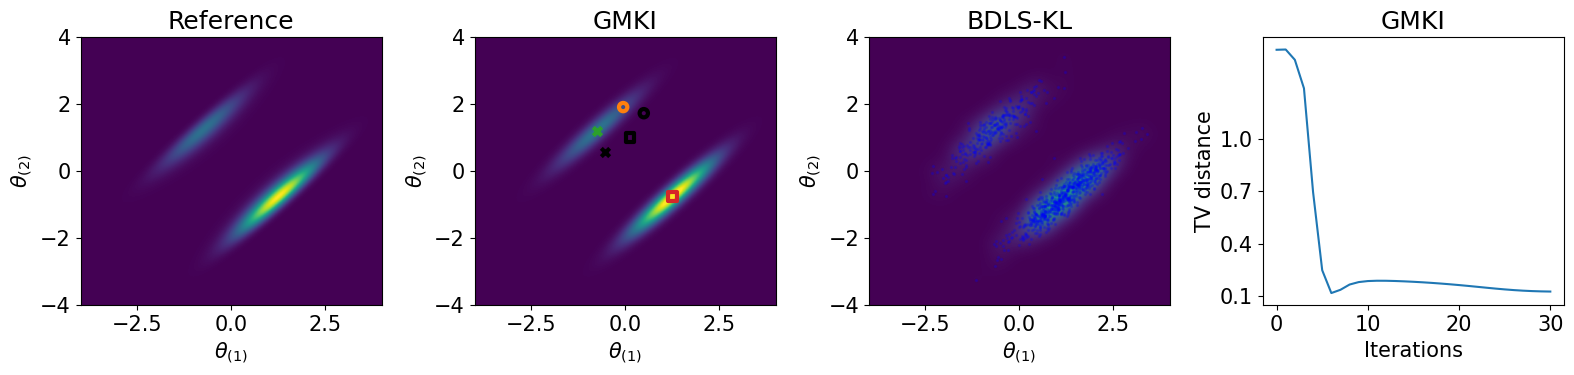

In [6]:
twomodal([0.5;0.0]; Run_Fisher_Rao=true)